In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from models import *
from learning import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [4]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
train_x, test_x = x_data[:5000].to(device), x_data[5000:].to(device)
train_y, test_y = y_data[:5000].to(device), y_data[5000:].to(device)

train_x, val_x = train_x[:4000].to(device), train_x[4000:].to(device)
train_y, val_y = train_y[:4000].to(device), train_y[4000:].to(device)

In [4]:
first_hyperparams = {
    'batch_size': [100],
    'lr':  [0.001, 0.003, 0.005, 0.01, 0.03, 0.05],
    'weight_decay': [0],
    'epochs': [20, 50, 100],
    'func': [F.relu, F.tanh],
    'window_size': [10, 20, 30],
    'hidden_size': [20, 30, 50],
}

grid_tdnn = GridSearch(first_hyperparams)

model_selection_history = grid_tdnn.tdnn_grid_search(train_x, train_y, val_x, val_y)

In [6]:
df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('grid_search.csv')
df.sort_values(by='val_mse', ascending=True).head(10)

,batch_size,lr,weight_decay,epochs,func,window_size,hidden_size,train_mse,val_mse
config_21,100,0.001,0,50,<function relu at 0x7fb85ab5b490>,20,20,0.000154,0.000354
config_130,100,0.005,0,50,<function relu at 0x7fb85ab5b490>,20,30,0.000105,0.000398
config_57,100,0.003,0,20,<function relu at 0x7fb85ab5b490>,20,20,0.000115,0.000405
config_40,100,0.001,0,100,<function relu at 0x7fb85ab5b490>,20,30,0.000098,0.000453
config_75,100,0.003,0,50,<function relu at 0x7fb85ab5b490>,20,20,0.000125,0.000495
config_156,100,0.005,0,100,<function tanh at 0x7fb85ab5beb0>,20,20,0.000167,0.000518
config_22,100,0.001,0,50,<function relu at 0x7fb85ab5b490>,20,30,0.000098,0.000523
config_26,100,0.001,0,50,<function relu at 0x7fb85ab5b490>,30,50,0.000088,0.000526
config_76,100,0.003,0,50,<function relu at 0x7fb85ab5b490>,20,30,0.000073,0.000533
config_42,100,0.001,0,100,<function relu at 0x7fb85ab5b490>,30,20,0.000123,0.000541


In [16]:
tdnn = TDNN(window_size=20, hidden_size=20, output_size=1).to(device)
train_dataset = TDNNDataset(train_x, train_y, window_size=20)
val_dataset = TDNNDataset(val_x, val_y, window_size=20)
train_loader = data.DataLoader(train_dataset, batch_size=100, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
t_h, val_h = train_tdnn(tdnn, train_loader, val_loader, lr=0.001, weight_decay=0, epochs=50, func=F.relu)

Epoch 0 - Train MSE: 0.033294268394820394 - Val MSE: 0.011118089780211449
Epoch 1 - Train MSE: 0.009460391267202795 - Val MSE: 0.00853636208921671
Epoch 2 - Train MSE: 0.006259256828343496 - Val MSE: 0.005427156575024128
Epoch 3 - Train MSE: 0.0035200150159653276 - Val MSE: 0.003147842362523079
Epoch 4 - Train MSE: 0.0019817453547148036 - Val MSE: 0.002022035187110305
Epoch 5 - Train MSE: 0.0013429196580545977 - Val MSE: 0.001611469080671668
Epoch 6 - Train MSE: 0.0011477853753603996 - Val MSE: 0.001490268623456359
Epoch 7 - Train MSE: 0.001097161040524952 - Val MSE: 0.0014560333220288157
Epoch 8 - Train MSE: 0.0010782254510559141 - Val MSE: 0.0014433966716751456
Epoch 9 - Train MSE: 0.0010650533004081808 - Val MSE: 0.001434006029739976
Epoch 10 - Train MSE: 0.0010459342360263691 - Val MSE: 0.0014133461518213153
Epoch 11 - Train MSE: 0.00100299762270879 - Val MSE: 0.0013620577519759536
Epoch 12 - Train MSE: 0.000931263281381689 - Val MSE: 0.0012802567798644304
Epoch 13 - Train MSE: 0.0

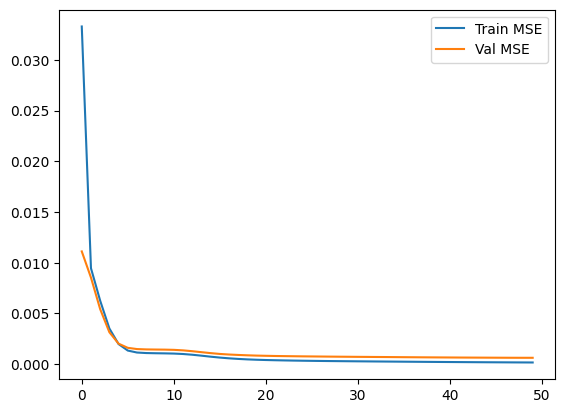

In [17]:
# this code is just a try to see how to plot
plt.plot(t_h, label='Train MSE')
plt.plot(val_h, label='Val MSE')
plt.legend()

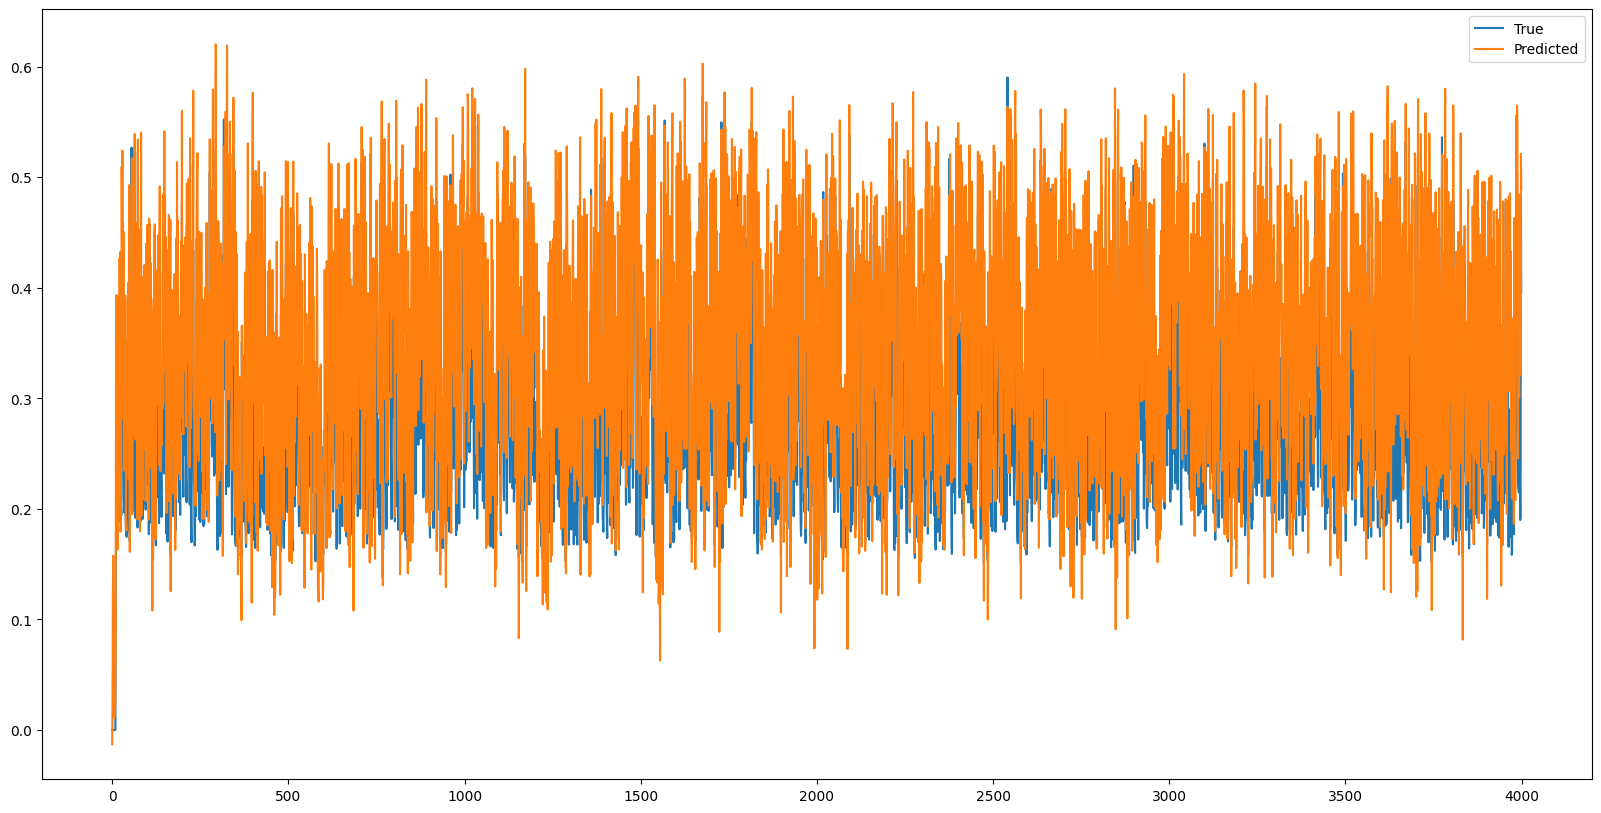

In [25]:
# this code is just a try to see how to plot
train_loader = data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
plt.figure(figsize=(20, 10))
for x, y in train_loader:
    with torch.no_grad():
        out = tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()